In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from matplotlib.colors import ListedColormap

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline


In [4]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


In [5]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


Problem 1:
---------

Now let's display some images from different classes to make sure they look fine in the expexted folder structure.


In [8]:
from IPython.display import display, Image
display(Image(filename="notMNIST_small/A/Q0NXaWxkV29yZHMtQm9sZEl0YWxpYy50dGY=.png"))
display(Image(filename="notMNIST_small/B/MTFTMDEgQmxhY2sgVHVlc2RheSBPZmZzZXQudHRm.png"))
display(Image(filename="notMNIST_small/C/Q0cgT21lZ2EudHRm.png"))
display(Image(filename="notMNIST_small/D/MTIgV2FsYmF1bSBJdGFsaWMgMTMyNjMudHRm.png"))
display(Image(filename="notMNIST_small/E/OEJhbGxTY3JpcHRTQ2Fwc1NTSyBJdGFsaWMudHRm.png"))
display(Image(filename="notMNIST_large/F/aG9uZXkgQm9sZC50dGY=.png"))
display(Image(filename="notMNIST_large/G/a3JvZWdlciAwNl82Ni50dGY=.png"))
display(Image(filename="notMNIST_large/H/a3JvZWdlciAwNF82NS50dGY=.png"))
display(Image(filename="notMNIST_large/I/a3JvZWdlciAwNl81Ni50dGY=.png"))
display(Image(filename="notMNIST_large/J/a3JvZWdlciAwNl82NS50dGY=.png"))


The images look ok. Was able to print images from 10 different folders.

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

Problem 2
--------

Now let's display the data by reading it from the pickle files. It should look a little different because they were normalized to have zero mean and equal variance.

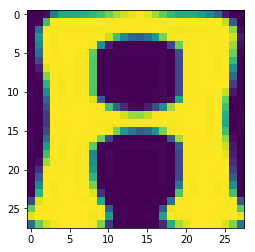

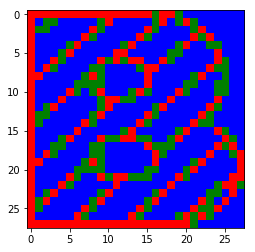

In [10]:
pickle_file = train_datasets[0] #All A's from dataset
with open(pickle_file, 'rb') as f:
    letter_set = pickle.load(f)  # unpickle
    sample_idx = np.random.randint(len(letter_set))  # pick a random image index
    sample_image = letter_set[sample_idx, :, :]  # extract a 2D slice
    #print(sample_image) Unncomment here if you want to see the numbers that will render the image
    plt.figure()
    plt.imshow(sample_image)  # display it


pickle_file = train_datasets[1] #All B's from dataset
with open(pickle_file, 'rb') as f:
    letter_set = pickle.load(f)  # unpickle
    sample_idx = np.random.randint(len(letter_set))  # pick a random image index
    sample_image = letter_set[sample_idx, :, :]  # extract a 2D slice
    #print(sample_image) Unncomment here if you want to see the numbers that will render the image
    plt.figure()
    cmap = ListedColormap(['b', 'g', 'r'])
    plt.imshow(sample_image, cmap=cmap)  # display it with a different color map


This looks ok, were able to print the images after storing it in arrays. Also changed the colormap on the B to mess around with the API.

Problem 3
--------
To check for balance data I will count the totals for each dataset. I will simply display how many records in each dataset.

In [11]:
for label, pickle_file in enumerate(train_datasets):
  with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        set_size = len(letter_set)
  print("Class " + str(label) + " contains "+ str(set_size))
    

Class 0 contains 52909
Class 1 contains 52911
Class 2 contains 52912
Class 3 contains 52911
Class 4 contains 52912
Class 5 contains 52912
Class 6 contains 52912
Class 7 contains 52912
Class 8 contains 52912
Class 9 contains 52911


That's balanced enough for me. Let's move on.

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [12]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [13]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

Problem 4
--------

Convince yourself that the data is still good after shuffling!

Let's count the data again per class per dataset:

In [14]:
for x in range(0, 10):
  print('Number of records with label ' + str(x) + ' in train: ' +str(len(train_labels[train_labels==x])))

for x in range(0, 10):
  print('Number of records with label ' + str(x) + ' in test: ' +str(len(test_labels[test_labels==x])))

for x in range(0, 10):
  print('Number of records with label ' + str(x) + ' in valid: ' +str(len(valid_labels[valid_labels==x])))




Number of records with label 0 in train: 20000
Number of records with label 1 in train: 20000
Number of records with label 2 in train: 20000
Number of records with label 3 in train: 20000
Number of records with label 4 in train: 20000
Number of records with label 5 in train: 20000
Number of records with label 6 in train: 20000
Number of records with label 7 in train: 20000
Number of records with label 8 in train: 20000
Number of records with label 9 in train: 20000
Number of records with label 0 in test: 1000
Number of records with label 1 in test: 1000
Number of records with label 2 in test: 1000
Number of records with label 3 in test: 1000
Number of records with label 4 in test: 1000
Number of records with label 5 in test: 1000
Number of records with label 6 in test: 1000
Number of records with label 7 in test: 1000
Number of records with label 8 in test: 1000
Number of records with label 9 in test: 1000
Number of records with label 0 in valid: 1000
Number of records with label 1 in 

Now let's try and print one image from each class from the training set to make sure randomization is keeping the labels associated with the correct images.

First 0 found at 12
First 1 found at 13
First 2 found at 3
First 3 found at 5
First 4 found at 0
First 5 found at 6
First 6 found at 2
First 7 found at 4
First 8 found at 14
First 9 found at 1


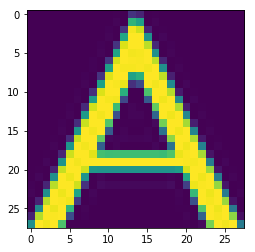

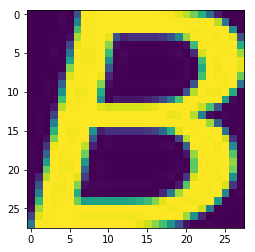

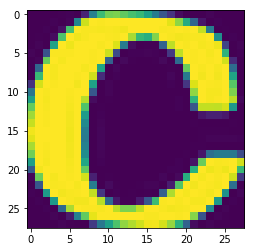

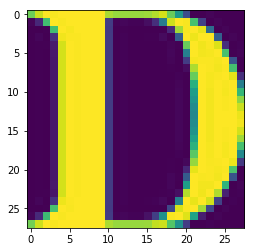

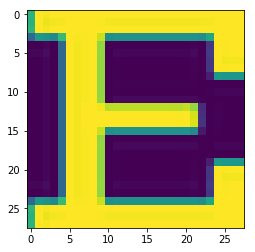

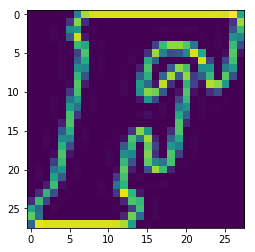

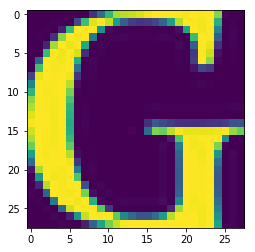

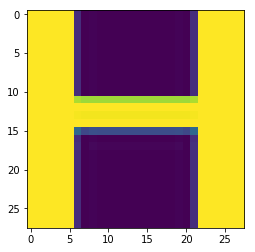

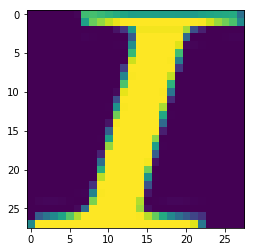

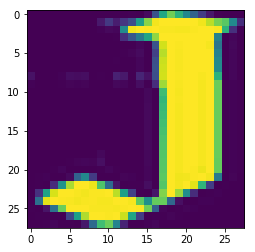

In [15]:
for x in range(0, 10):
    #print(train_labels)
    indexes = np.where(train_labels==x)
    print('First '+ str(x) + ' found at ' + str(indexes[0][0]))
    sample_image = train_dataset[indexes[0][0], :, :]
    plt.figure()
    plt.imshow(sample_image)  # display it


That seems good enough.


Finally, let's save the data for later reuse:


In [16]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)



Compressed pickle size: 690800506


Problem 5
=====

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.


In [30]:
pickle_file = os.path.join('.', 'notMNIST.pickle')

try:
    #Read pickle file
    f = open(pickle_file, 'rb')
    unpickled_data = pickle.load(f)
     
except Exception as e:
  print('Unable to read data to', pickle_file, ':', e)
  raise

# Just print some labels to make sure the data is ok
print(unpickled_data['train_labels'])

# Get datasets from pickle file
train_dataset = unpickled_data['train_dataset']
valid_dataset = unpickled_data['valid_dataset']
test_dataset  = unpickled_data['test_dataset']
train_labels  = unpickled_data['train_labels']
valid_labels  = unpickled_data['valid_labels']
test_labels   = unpickled_data['test_labels']

# Concat datasets 
full_dataset = np.concatenate((train_dataset, valid_dataset))
full_dataset = np.concatenate((full_dataset, test_dataset))
full_labels = np.concatenate((train_labels, valid_labels))
full_labels = np.concatenate((full_labels, test_labels))

# Shape into one dimension as required for lexsort
print('Before reshape: ', full_dataset.shape)
dataset_2d = full_dataset.reshape(full_dataset.shape[0],-1)
print('After reshape: ', dataset_2d.shape)
print(dataset_2d[0].shape)
print(dataset_2d.T.shape)

# Group same images together and then remove duplicates.
# This approach is faster because it doesnt need to loop i x j times through all datasets
sortidx = np.lexsort(dataset_2d.T)
clean_dataset = full_dataset[sortidx][np.append(True,(np.diff(dataset_2d[sortidx],axis=0)!=0).any(1))]
clean_labels = full_labels[sortidx][np.append(True,(np.diff(dataset_2d[sortidx],axis=0)!=0).any(1))]
print('Shape after cleaning dataset: ', clean_dataset.shape)
print('Removed from dataset: ', full_dataset.shape[0] - clean_dataset.shape[0])
print('Shape after cleaning labels: ', clean_labels.shape)
print('Removed from labels: ', full_labels.shape[0] - clean_labels.shape[0])


[4 9 6 ..., 2 4 4]
Before reshape:  (220000, 28, 28)
After reshape:  (220000, 784)
(784,)
(784, 220000)
Shape after cleaning dataset:  (204895, 28, 28)
Removed from dataset:  15105
Shape after cleaning labels:  (204895,)
Removed from labels:  15105


Now we don't have duplicates, let's randomize, split again and create a 2nd non duplicate pickle.

In [1]:
#Randomize full data again
print(clean_labels)
clean_dataset, clean_labels = randomize(clean_dataset, clean_labels)
print(clean_labels)

#Make sure labels and data are still aligned
for x in range(0, 10):
    #print(train_labels)
    indexes = np.where(clean_labels==x)
    print('First '+ str(x) + ' found at ' + str(indexes[0][0]))
    sample_image = clean_dataset[indexes[0][0], :, :]
    plt.figure()
    plt.imshow(sample_image)  # display it


#Split and pickle
test_ds_clean = clean_dataset[0:10000]
test_lb_clean = clean_labels[0:10000]
print('test_ds_clean.shape: ', test_ds_clean.shape)
print('test_lb_clean.shape: ', test_lb_clean.shape)

valid_ds_clean = clean_dataset[10000:20000]
valid_lb_clean = clean_labels[10000:20000]
print('valid_ds_clean.shape: ', valid_ds_clean.shape)
print('valid_lb_clean.shape: ', valid_lb_clean.shape)

train_ds_clean = clean_dataset[20000:300000]
train_lb_clean = clean_labels[20000:300000]
print('train_ds_clean.shape: ', train_ds_clean.shape)
print('train_lb_clean.shape: ', train_lb_clean.shape)


pickle_file = os.path.join(data_root, 'notMNIST_clean.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_ds_clean': train_ds_clean,
    'train_lb_clean': train_lb_clean,
    'valid_ds_clean': valid_ds_clean,
    'valid_lb_clean': valid_lb_clean,
    'test_ds_clean': test_ds_clean,
    'test_lb_clean': test_lb_clean,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)
    
    


NameError: name 'clean_labels' is not defined

Now we can use the pickle file above when a sanitized version of our dataset is needed (as per the optional question).

For near duplicates, let's mess around with the np.diff function:

In [73]:
#Get our clean dataset and compare the first 3 images:
diff = np.diff(train_ds_clean[0:4], axis=0)
print('Shape is ', diff.shape)
diff = np.absolute(diff)
diff_sums = np.asarray(list(map(sum, diff)))
diff_sums = np.asarray(list(map(sum, diff_sums)))
print(diff_sums.shape)
print(diff_sums)
#print('Zip is', zipped) 
#print('Abs Diff is', np.absolute(diff).sum(axis= 0))
#print(diff)

Shape is  (3, 28, 28)
(3,)
[ 364.80783224  369.98823643  317.76078558]


Problem 6
=====

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

In [31]:
# Import the sklearn library
from sklearn.linear_model import LogisticRegression

#Reshape the data
sample_size = 20000
train_dataset = train_dataset[0:sample_size]
train_labels = train_labels[0:sample_size]

train_dataset = train_dataset.reshape(train_dataset.shape[0],-1)
test_dataset = test_dataset.reshape(test_dataset.shape[0],-1)

print('New shape (train_dataset): ', train_dataset.shape)
print('New shape (train_labels): ', train_labels.shape)
print('New shape (test_dataset): ', test_dataset.shape)





New shape (train_dataset):  (20000, 784)
New shape (train_labels):  (20000,)
New shape (test_dataset):  (10000, 784)


The lines below will actually call the LogisticRegression class to train the model and then show the results

In [32]:
# fit the model
classifier = LogisticRegression(random_state = 0)
classifier.fit(train_dataset, train_labels)

# Predicting the Test set results
predicted_labels = classifier.predict(test_dataset)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predicted_labels)
print(cm)

[[870  10   4  11   9   9  13  34  16  24]
 [ 12 866   5  32  21  12  22  11  13   6]
 [  7   5 922   1  23   6  13   8   8   7]
 [ 12  16   3 907   8  13   5   8   8  20]
 [  8  35  49   8 807  26  16  12  28  11]
 [ 12   8   7   7   7 898  12  10  16  23]
 [ 10   7  40  10  17  11 858   9  21  17]
 [ 31  18   7   8  26  22  13 833  24  18]
 [ 16   4   8   8  15  16  19  17 846  51]
 [ 14   2  10   8   6  21   9   4  33 893]]
